In [1]:
import numpy as np
import matplotlib.pyplot as plt

from zsindy.dynamical_models import DynamicalSystem, lorenz
from zsindy.ml_module import ZSindy
from tqdm import tqdm 


In [32]:
# ZSindy parameters
poly_degree = 2
lmbda = 1e5 # Regularization parameter
zsindy_num_terms = 4 # Maximum number of terms to include in the model
eta = 0.2 # Noise


In [33]:
# Simulate the dynamical system
x0 = (0, 1, 1.05)
tend = 20
dt = 0.01
rho = dt/eta*np.sqrt(2) # Resolution parameter
print(rho)
args = (10, 28, 8/3)

# Built-in simulators for dynamical systems
dyn = DynamicalSystem(lorenz, poly_degree, args, num_variables=len(x0))
X = dyn.solve(x0, dt, tend)
true_coefs = dyn.true_coefficients
varnames = dyn.varnames
lambda_norm = dyn.time/dt * rho**2
num_dims = X.shape[1]

# Add Noise
X += eta * np.random.randn(*X.shape)

0.07071067811865475


In [34]:
## Z-Sindy
zmodel = ZSindy(rho=rho, 
                lmbda=lmbda, 
                max_num_terms=zsindy_num_terms, 
                poly_degree=poly_degree,
                variable_names=varnames)

zmodel.fit(X, dyn.time)

print("\nZ-Sindy Model:")
zmodel.print()
z_x_pred = zmodel.simulate(x0, dyn.time)
z_xdot_pred = zmodel.predict()


Z-Sindy Model:
( x )' =  + -9.8881 x + 9.9020 y
( y )' =  + 27.4575 x + -0.8720 y + -0.9853 x*z
( z )' =  + -2.6625 z + 0.9982 x*y


In [35]:

# Predictions for zsindy
z_coef_error = np.sqrt((zmodel.coefficients() - true_coefs)**2)
z_std_coefs = np.sqrt(zmodel.coefficients_variance())
z_mean_coefs = zmodel.coefficients()


In [36]:
z_ensemble_trials = 10
num_feats = zmodel.coefficients().shape[1]

# Generate coefficients from distribution
z_coef_ensemble = np.zeros((z_ensemble_trials, num_dims, num_feats))

for i in tqdm(range(z_ensemble_trials)):
    for j in range(num_dims):
        z_coef_ensemble[i, j, :] = np.random.normal(zmodel.coefficients()[j, :], z_std_coefs[j])

# Simulate models
z_xdot_pred_ensemble = np.zeros((z_ensemble_trials, len(dyn.time), num_dims))
z_xpred_ensemble = np.zeros((z_ensemble_trials, len(dyn.time), num_dims))

print(f"\nSimulating ensemble of {z_ensemble_trials} Z-Sindy models...")
for i in tqdm(range(z_ensemble_trials)):
    z_xdot = zmodel.Theta @ z_coef_ensemble[i, :, :].T
    z_xpred = zmodel.simulate(X[0], dyn.time, coefs=z_coef_ensemble[i, :, :])

    z_xdot_pred_ensemble[i, :, :] = z_xdot
    z_xpred_ensemble[i, :, :] = z_xpred


100%|██████████| 10/10 [00:00<00:00, 11844.97it/s]



Simulating ensemble of 10 Z-Sindy models...


100%|██████████| 10/10 [00:00<00:00, 13.31it/s]


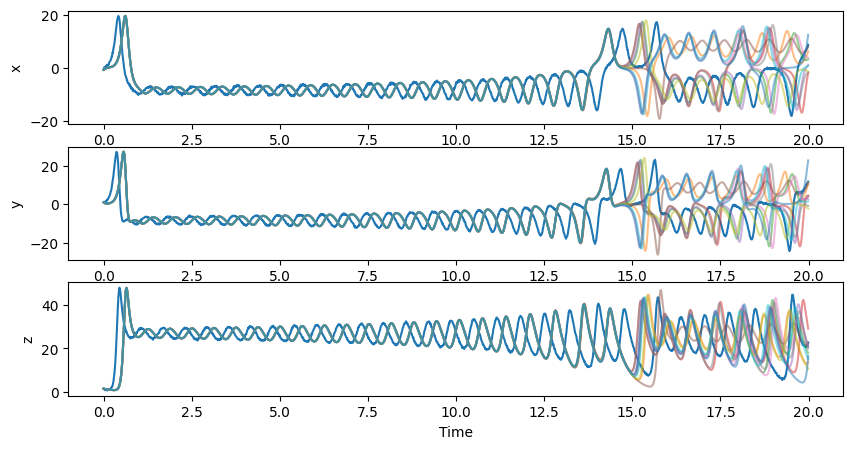

In [37]:

# Visualize simulation results
plt.figure(figsize=(10, 5))
for i in range(num_dims):
    plt.subplot(num_dims, 1, i+1)
    plt.plot(dyn.time, X[:, i], label='True')
    plt.plot(dyn.time, z_xpred_ensemble[:, :, i].T, alpha=0.5)
    plt.xlabel('Time')
    plt.ylabel(varnames[i])

plt.show()


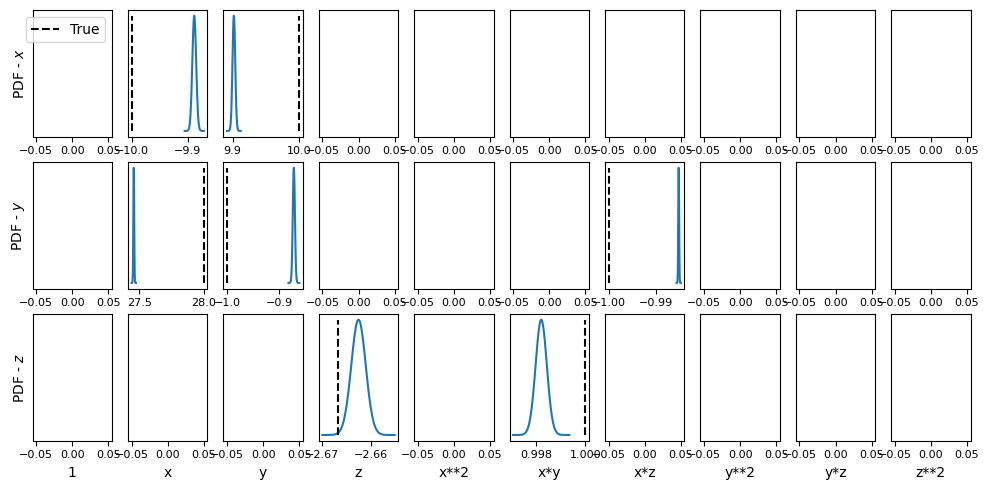

In [38]:
def gaussian(x, mu, sig):
    return 1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)

feat_names = zmodel.get_feat_names()

fig, axes = plt.subplots(num_dims, num_feats, figsize=(10, 5))
for i in range(num_dims):
    for j in range(num_feats):

        # five_std = 5 * z_std_coefs[i, j]
        five_std = 5 * z_std_coefs[i, j]
        x_range = np.linspace(z_mean_coefs[i, j] - five_std, z_mean_coefs[i, j] + five_std, 100)

        z_pdf = 0
        if z_std_coefs[i, j] > 0:
            z_pdf = gaussian(x_range, z_mean_coefs[i, j], z_std_coefs[i, j])
            axes[i, j].plot(x_range, z_pdf, label='Z-Sindy')

        if j == 0:
            axes[i, j].set_ylabel(f'PDF - ${varnames[i]}$')
        if i == len(varnames)-1:
            axes[i, j].set_xlabel(f'{feat_names[j]}')
        
        axes[i, j].plot([true_coefs[i, j], true_coefs[i, j]], [0, max([np.max(z_pdf)])], 'k--', label='True')
        
        # axes[i, j].set_xticks([])
        axes[i, j].tick_params(axis='x', labelsize=8)
        axes[i, j].set_yticks([])
        # axes[i, j].set_title('Coefficient distributions for ' + str(self.varnames[i]))
        if i == 0 and j == 0:
            axes[i, j].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.2)


